In [11]:
# Load a capture file or example packets
# Expected: either a pyshark.FileCapture, a list of packets, or an iterable
# If you have a file 'data/sample.pcapng', set cap to a FileCapture; otherwise,
# provide guidance friendly defaults so the notebook runs without TypeError.
from typing import Iterable

cap = None  # will be set to an iterable of packets later

# Common imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from datetime import datetime

# Networking/packet analysis
import pyshark
import scapy.all as scapy
import networkx as nx

# Helper: inline plots
%matplotlib inline


# TCP Handshake Analyzer — Measuring Connection Setup

**Goal:** Parse and visualize the three-way handshake (SYN → SYN-ACK → ACK) in a packet capture, compute RTT, and understand retransmissions.

**Connection to previous labs**
- From WireScope & CSMA/CD → bit-level timing and collisions influence latency.
- From ARP Scope → IP and MAC resolution must finish before handshake starts.
- Now → we inspect the *transport layer* behavior that rides on those physical realities.


Detected 1 complete handshakes


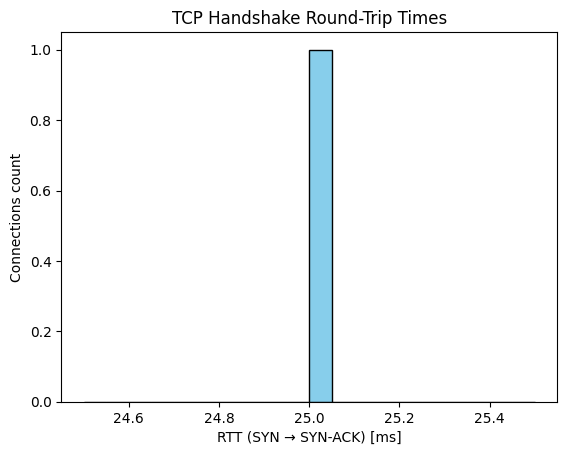

Average RTT ≈ 25.00 ms
SYN retransmissions: 0


In [12]:
def find_handshakes(capture):
    handshakes = []
    flows = {}
    for pkt in capture:
        if 'TCP' not in pkt: continue
        flags = pkt.tcp.flags
        ts = float(pkt.sniff_timestamp)
        src, dst = pkt.ip.src, pkt.ip.dst
        key = tuple(sorted([src, dst]))     # bidirectional key

        if flags == '0x0002':               # SYN
            flows[key] = {'syn': ts}
        elif flags == '0x0012' and key in flows:   # SYN-ACK
            flows[key]['synack'] = ts
        elif flags == '0x0010' and key in flows:   # ACK
            flows[key]['ack'] = ts
            handshakes.append(flows[key])
            del flows[key]
    return handshakes

# Resolve capture source: if a local PCAP exists, use it; otherwise, synthesize a tiny example iterable
try:
    if cap is None:
        import os
        sample_path = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'data', 'sample.pcapng') if '__file__' in globals() else 'data/sample.pcapng'
        if isinstance(sample_path, str) and os.path.exists(sample_path):
            cap = pyshark.FileCapture(sample_path, keep_packets=False)
        else:
            # Minimal synthetic packets with the attributes we access below
            class P:
                def __init__(self, ts, src, dst, flags, dport=443):
                    self.sniff_timestamp = str(ts)
                    self.ip = type('ip', (), {'src': src, 'dst': dst})()
                    self.tcp = type('tcp', (), {'flags': flags, 'dstport': dport})()
                def __contains__(self, item):
                    return item == 'TCP'
            now = 1_700_000_000.0
            cap = [
                P(now+0.000, '10.0.0.2', '10.0.0.5', '0x0002'),   # SYN
                P(now+0.025, '10.0.0.5', '10.0.0.2', '0x0012'),   # SYN-ACK
                P(now+0.030, '10.0.0.2', '10.0.0.5', '0x0010'),   # ACK
            ]
except Exception as e:
    # Fallback to empty list to avoid TypeError in iteration
    cap = []

handshakes = find_handshakes(cap)
print(f"Detected {len(handshakes)} complete handshakes")

# Guard against empty datasets
if not handshakes:
    print("No complete handshakes found. Ensure 'data/sample.pcapng' exists or set 'cap' to a pyshark capture.")
    rtts = []
else:
    rtts = [hs['synack'] - hs['syn'] for hs in handshakes]
plt.hist(np.array(rtts)*1000, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("RTT (SYN → SYN-ACK) [ms]")
plt.ylabel("Connections count")
plt.title("TCP Handshake Round-Trip Times")
plt.show()

if rtts:
    print(f"Average RTT ≈ {np.mean(rtts)*1000:.2f} ms")
else:
    print("Average RTT: N/A (no handshakes)")

def count_syn_retransmissions(capture):
    syn_times = {}
    retrans = 0
    for pkt in capture:
        if 'TCP' not in pkt: continue
        if pkt.tcp.flags == '0x0002':
            key = (pkt.ip.src, pkt.ip.dst, pkt.tcp.dstport)
            if key in syn_times and float(pkt.sniff_timestamp)-syn_times[key] > 0.5:
                retrans += 1
            syn_times[key] = float(pkt.sniff_timestamp)
    return retrans

try:
    print("SYN retransmissions:", count_syn_retransmissions(cap))
except TypeError:
    print("SYN retransmissions: N/A (invalid capture type)")


### 🧠 Interpreting the handshake

1. **SYN** → Client proposes initial sequence number.
2. **SYN-ACK** → Server acknowledges and proposes its own.
3. **ACK** → Client confirms; connection established.

- The time between SYN and SYN-ACK ≈ RTT.
- Multiple SYNs → possible packet loss or congestion.
- Each retransmission adds delay to the user’s first byte latency.


### 🌐 Link back to the lower labs
- If **reflections** or **collisions** (WireScope / CSMA-CD) occur, they increase the apparent RTT or trigger SYN retries.
- If **ARP** is unresolved, the SYN is delayed until the MAC address is known.
- At the physical level, jitter or aliasing of the clock (NyquistLab) manifests as packet-timing variability.
- Thus, the TCP handshake is a transport-layer mirror of your entire stack’s health.


1. What are the three steps of the TCP handshake?
2. What does a missing SYN-ACK indicate?
3. How could a physical-layer reflection or CSMA/CD collision show up in this analysis?
4. Why do modern networks measure RTT to adjust TCP window size?


**Summary — Synchronization Across the Stack**

- TCP handshake turns electrical pulses into a reliable session.
- Each lab below contributes:
  Nyquist → timing integrity WireScope → signal integrity ARP → reachability CSMA/CD → medium discipline.
- Now we see how transport protocols depend on those physical truths.
